In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import os

import time
import random
from datetime import datetime, timedelta
from urllib.request import urlopen

from pylib.draw_graph import draw_graph

In [3]:
# Note: This notebook takes a while to run.  It is recommended
# that you adjust the iterations number up and then execute the
# entire notebook, before reading through it.
num_iterations = 500 #6000 takes about two hours to train and generates ok text

<!-- requirement: pylib/__init__.py -->
<!-- requirement: pylib/draw_graph.py -->
<!-- requirement: small_data/strata_abstracts.txt -->

# Recurrent Neural Networks


Up to now, we have been dealing only with **feed-forward** networks.  These take in some input features and feed those through the network to produce the output.  For many problems, this is enough.  If you want to classify images of cats, all you care about are the features from one given image.  You don't care about what the previous (or next) picture was.

However, much of the world's data is not time-independent.  Some of this is very obvious: If you're trying to predict future stock prices, knowing the past prices is probably going to be useful.  Other cases might not be immediately clear.  A prime example is language processing.  Order is important; there's a big difference between "dog bites man" and "man bites dog".  Similarly, speech recognition, optical character recognition, and text summarizing algorithms all benefit from knowing something about the previous inputs.

We encountered the same sort of issue when we wanted to classify images.  Knowing what's nearby in space is very important, so we designed a network architecture to reflect those priorities.  In that case, we developed convolutional nets that combined features nearby in space.  Now, we need to design a network that gives us nearby-in-time features.

Such networks are known as **recurrent** neural networks (RNN).  To illustrate how they work, we'll adopt a simple sketch notation.  Let this represent a feed-forward of the kind we've already dealt with.

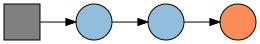

In [4]:
draw_graph("feed-forward")

The two blue circles represent hidden layers.  In the feed-forward architecture, they just feed activations further through the network.

In contrast, we represent a recurrent network like so:

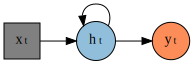

In [5]:
draw_graph("recurrent")

The hidden layers get input activations not just from the layer below, but from their (or other layer's) output at a previous step.  These hidden activations incorporate the previous state of the network, thereby providing some memory of the previous inputs.  During training, the recurrent network will learn how to weight both the current features and the previous state in making decisions.

An alternative approach would be to have inputs not just for the current time, but for *n* previous times.  As long as the connections are set up appropriately, this could give similar performance.  However, it would require inputs of a fixed length.  In contrast, RNNs can take inputs of arbitrary length, since all of the previous input, of whatever length, is represented in the hidden activations.

It was proven in 2006 by Schäfer and Zimmerman that RNNs with sigmoid activations are **Turing-complete**.  That is, any program can be written by giving a RNN the appropriate weights.  This is only a theoretical result; there is no method to find those weights for a particular task.  However, it's easier to use an optimization algorithm to explore the space of weight matrices than the space of Python programs, for example.


## Backpropagation through time


You might remember that we said at the very beginning of the very first notebook that TensorFlow graphs must be acyclic.  Yet we just drew a diagram of a RNN with a loop in it.  How can we put this into TensorFlow?

The trick is to **unroll** or unfold the RNN through time.  That is, the recurrent edge is pointed not back to the same node, but to another copy, representing the next step in time.  And in that copy, this edge points to yet another copy, giving us a structure like so:

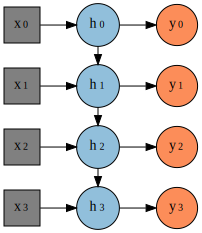

In [6]:
draw_graph("unrolled")

Although somewhat unusual, this is a perfectly good feed-forward network, and the standard backpropagation algorithm can be used with it.  The only wrinkle is that the weight matrices in all of the copies must stay in sync.  Therefore, we update them by summing all the gradients from all copies, similar to the way we handled convolutional filters.  This process in known as "backpropagation through time".


## Long-short term memory


While basic RNNs, such as the ones we've seen so far, solve our purpose of handling sequential data, it turns out they are only useful when we are dealing with short-term dependencies. A vanilla RNN might successfully predict the last word of a sentence like *"He is 30 years ____"*, but it will fail in examples which require longer memory and understanding of the context, such as *"I was born and raised in France. ...[several unrelated sentences]... I speak fluent ____"*. 

The reason for this is the problem of vanishing and exploding gradients. In a naive implementation of a RNN, we can write the prediction of a feed-forward network as a set of nested functions.

$$ p = f_n\left( f_{n-1}\left( \cdots f_2\left( f_1\big( x W_1 \big) W_2 \right) \cdots W_{n-1} \right) W_n \right) $$

(We've dropped the bias terms for simplicity.)  To update $W_1$, for example, we need to calculate

$$ \frac{\partial p}{\partial W_1} = f_n' \big(\cdots\big) W_n \cdot f_{n-1}'\big(\cdots\big) W_{n-1} \cdot\cdots\cdot f_2'\big(\cdots\big) W_2 \cdot f_1'\big(x W_1) \cdot x$$

If each of these terms are greater than one, the whole gradient will become large.  This will require a small learning-rate to avoid the optimizer diverging.  If each of the the terms are less than one, the gradient will vanish, and the weight won't change appreciably.

This is a general problem in deep networks and has been dubbed the "fundamental problem of deep learning". But with a generic network we can at least hope that we'll have terms both less than and greater than one, so that the whole gradient remains finite.  In an RNN, though, these nested functions represent previous copies of the network, so all of the weights are the same!  Unless they happen to be exactly one, we're guaranteed to get an explosion or a vanishing! We might get away with this if $n$ is small, but small $n$ corresponds to the network having knowledge of only a couple steps back in our sequence of data. 

Several extensions for RNNs that would solve this problem have been proposed, but the current *de facto* standard are **long short-term memory** (LSTM) networks. In LSTMs the simple neurons are replaced with more complex LSTM cells that get around the problem by breaking the direct coupling between the previous input, the state, and the output.  

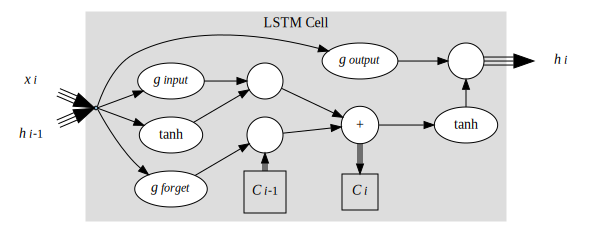

In [7]:
draw_graph("LSTM_full")

The diagram shows a fairly typical LSTM cell. Same as before what goes into the cell is new input $x_i$ as well as the output of the cell at previous time step, $h_{i-1}$. Compared to a simple neuron the difference with an LSTM cell is that it has another piece of information, its **internal state** $C_i$. At each time step we update both the cell's internal state $C_i$ and the output of the cell $h_i$ like so:


$$C_{i} = g_{forget}\otimes C_{i-1} + g_{input} \otimes \tanh(W_x\cdot x_{i} + W_h\cdot h_{i-1} + b)$$

$$h_{i} = g_{output} \otimes \tanh(C_i)$$

The operations with the circles around them are point-wise: $g$ and $C$ and $h$ all have the same shape, and you are multiplying individual elements.  What exactly that shape _is_ is a decision you get to make.  Often a scalar is chosen and you just make more cells, but vectors of various sizes are common as well.

The three different **gates** determine how much we let new input in ($g_{input}$), how much we want the cell to keep/forget it's internal state ($g_{forget}$) and how much of the cell state we’re going to output ($g_{output}$). These various gates use a sigmoid function to produce values between $0$ and $1$. They are calculated from the input and previous output, so that decisions about how to weight new input against the stored state are made dynamically.  They are given by

$$g_m(x_i,h_{i-1}) = \mathrm{sigmoid}(W^m_x\cdot x_i + W^m_h\cdot h_{i-1} + b)$$

where each gate $g_m$ has its own $W^m_x$ and $W^m_h$ parameters, and the sigmoid is again applied point-wise.

With all of this combined, LSTMs gain their property of selectively remembering patterns for long durations of time. 

There are several elaborations commonly added to the basic LSTM cell. One is peephole connections, which connect the internal state to the gates inside of the cell. There is some evidence that these improve the performance tasks requiring precise intervals. This feature is built into the LSTM cell provided by TensorFlow.


## Applications


Layers of recurrent cells are typically not used alone.  At the very least, a full-connected feed-forward layer is used following the recurrent layer.  This translates the individual memories into the expected output.  More complicated architectures are common, with several recurrent and several feed-forward layers combined.  Convolutional layers may also be used when the problem calls for them, for example in processing video.

Recurrent networks can be used for a number of different applications.  The examples we've drawn so far illustrate **sequence labeling**.  For each input, we calculate all the way through to the output.  This could be used, for example, to classify words in a sentence by their part of speech.  We need a label for each word, and the recurrent nature lets us use the past words to differentiate between, for example, the word "rows" in "Jack rows the boat" and "Jack walked between rows of wheat."

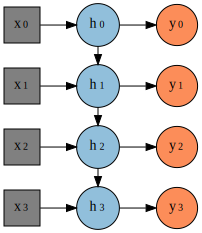

In [8]:
draw_graph("unrolled")

Sometimes, we care only about a single label for the whole sequence.  This is known as **sequence classification**.  We read the output associated only with the final input.  The recurrent nature ensures that this output has information from all of the inputs.  This could be used to classify the sentiment of a review text, for example.

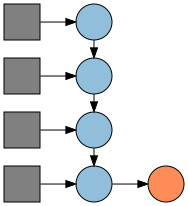

In [9]:
draw_graph("classification")

The situation is essentially reversed for **sequence generation**.  In this case, we take only a single input and wish to generate a whole sequence of output.  We can do this by feeding the output from one step (suitably processed, perhaps) as input to the next time step.  This can be used to generate text that resembles some corpus, as we demonstrate below. 

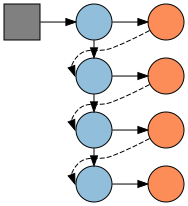

In [10]:
draw_graph("generation")

The ideas of classification and generation can be combined in **sequence translation**.  Here, an input sequence is fed into a network to establish a certain internal state.  This state is then used as the start of a decode sequence.  This can be done with two related RNNs or with a single one.  In the latter case a special token is needed to indicate to the network when to start outputting the translated version, as illustrated below.  Google used such networks for its [recent improvement](https://www.nytimes.com/2016/12/14/magazine/the-great-ai-awakening.html?_r=0) of its translation service.

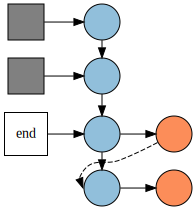

In [11]:
draw_graph("translation")

## Example: Generating strata abstracts


Here, we demonstrate a simple example of using sequence generation to create text.  We will train a neural network on a corpus of data consisting of abstracts of talks from past Strata conferences.  The networks will be trained to predict the next letter that appears in the abstract.  Once trained, the network can be used to generate an abstract by starting it off with a seed, and then continuing the sequence with letters chosen according the the probabilities output by the network.

We start by reading in the data we've already downloaded.  The abstracts are saved in a text file, one per line.

In [12]:
txt = open('small_data/strata_abstracts.txt', 'r').read().lower()

print(len(txt))
print()
print(txt[:1000])

1525206

samoa is an open-source platform for mining big data streams that runs on several distributed stream processing engines (such as s4 and storm), and includes streaming algorithms for the most common machine learning tasks such as classification and clustering. more info at http://samoa-project.net
how to extend your toolbox to solve more big data problems with less effort. aws provides a set of big data services that are elastic, scalable and highly available out of the box. learning best practices and tips of how to integrate them together and with your architecture adds to your abilities to provide fast and reliable big data solutions.
live demo of building an intelligent big data application from a web console. the tools and apis behind are built on top of spark, shark, tachyon, mesos, aurora, cassandra, ipython and include: elt pipeline (ingestion and transformation), data warehouse explorer, export to nosql and generated apis, predictive model building, training and publis

We'll want to one-hot encode the characters, so first we need to convert them to numbers. We could just take their ASCII values, but this would give us a larger vocabulary than we need. So instead we work out our own encoding, based on the characters we actually see.

In [13]:
chars = list(set(txt))
data = [chars.index(c) for c in txt]
print('Count of unique characters (i.e., features):', len(chars))

Count of unique characters (i.e., features): 64


We will be training with the minibatch method. This function will generate a batch of data. Each batch contains `batch_size` sequences, each `time_steps` in length. (Note that, for simplicity, we are ignoring the fact that newlines should end the abstract.) The labels to be predicted are the following letters.


In [14]:
def get_next_batch(batch_size, time_steps, data):
    x_batch = np.zeros((batch_size, time_steps))
    y_batch = np.zeros((batch_size, time_steps))
    
    batch_ids = range(len(data) - time_steps - 1)
    batch_id = random.sample(batch_ids, batch_size)
    
    for t in range(time_steps):
        x_batch[:, t] = [data[i+t] for i in batch_id]
        y_batch[:, t] = [data[i+t+1] for i in batch_id]
   
    return x_batch, y_batch

In [15]:
get_next_batch(1, 5, data)

(array([[28., 37.,  6., 62., 47.]]), array([[37.,  6., 62., 47., 45.]]))

We've chosen an architecture with 2 layers of 256 LSTM cells.  We will train on batches of 50 sequences of length 150. 

In [16]:
lstm_size = 256

time_steps = 150
batch_size = 50

Now we define a function that creates our model which is a sequential stack of two LSTM layers, each with `lstm_size` many cells. We make sure that both LSTM layers return sequences (`return_sequences=True`) so that the next layer doesn't receive randomly scattered data. Because each label we are trying to predict is a sequence, we also need to use the `TimeDistributed` wrapper layer. Notice also that we set `stateful = True`. That is because to generate the text, we'll need to run the network one step at a time, while preserving the internal state. This way, we will be able to keep feeding back in the character that we produced in the previous step to move forward. LSTM networks are stateful, but by default Keras implementation resets the state of the network after call of the 'predict' function. By setting `stateful = True` we will reset the state manually when we want. We finish off with a fully connected layer with ‘softmax’ activation and with number of neurons equal to the number of unique characters.

In [17]:
def create_LSTM_model(num_lstm_cells, input_batch_size, time_steps):
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(num_lstm_cells,
                                batch_input_shape=(input_batch_size, time_steps, len(chars)), 
                                return_sequences=True, stateful=True))
    model.add(keras.layers.LSTM(num_lstm_cells, 
                                batch_input_shape=(input_batch_size, time_steps, len(chars)), 
                                return_sequences=True, stateful=True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(len(chars), activation='softmax')))
    
    return model

Because we set our LSTM layers to have `stateful = True`, we had to explicitly specify the batch size as a dimension in the input shape. However that also means that when we make predictions, we must adhere to this same batch size. But we would like to train the network on batch size equal to `batch_size` and then make predictions with batch size equal to 1 so that every one character we produce, we can keep feeding back in to move forward. So because we want to use different batch sizes for training and predicting, we will create two models. The first we will train and the second we will use for predicting by copying the weights from the fit network to create a new network with the pre-trained weights. For training we will use the Root Mean Square Propagation (RMSProp) optimizer that attempts to set a custom learning rate for each parameter. It has been found to work well with RNNs.We will also set `time_steps` to None for the predicting network so that we can seed it with a string of any length.

In [18]:
model_training = create_LSTM_model(lstm_size, batch_size, time_steps)
RMSoptimizer = keras.optimizers.RMSprop(lr=0.003)
model_training.compile(loss='categorical_crossentropy', optimizer=RMSoptimizer)

model_predicting = create_LSTM_model(lstm_size, 1, None)

For the actual generation, we first run the network on some seed text. The last output gives us a set of probabilities for the next letter. We choose that letter with those probabilities, append it to the string we are generating, and then advance the state of the network as if this were the next input. We use the `model_predicting` for predictions and when we are done predicting, we reset the states.

Notice that we also need to one-hot encode the input and output. After one-hot encoding, the resulting arrays have the shape that the Keras LSTM input layer requires: (batch_size, time_steps, features) where batch_size is the number of sequences, time_steps is the size of observations in each sample, and features is the number of possible observable features (i.e., characters in our case).

In [19]:
from tensorflow.keras.utils import to_categorical as one_hot

def generate_text(seed, len_test_txt=500):
    
    # copy weights from trained model to predicting model
    trained_weights = model_training.get_weights()
    model_predicting.set_weights(trained_weights)
    
    seed = seed.lower()
    gen_str = seed
    
    # turn seed from letters to numbers so we can then one-hot encode it
    seed = [chars.index(c) for c in seed]

    for i in range(len_test_txt):
        
        # one hot encode the seed
        seed_oh = one_hot(seed, num_classes = len(chars))
        
        # reshape the seed into the shape the input layer of lstm needs
        seed_oh = np.reshape(seed_oh, newshape = (1, -1, len(chars)))
        
        #predicting
        char_probabilities = model_predicting.predict(seed_oh, verbose = 0)[0][0]
        pred_index = np.random.choice(range(len(chars)), p = char_probabilities)
        gen_str += chars[pred_index]

        #update seed to be the predicted character
        seed = pred_index
        
    model_predicting.reset_states()
    
    return gen_str

And now we're ready to go! We'll run the optimizer for a while. As we go, we'll print out sample text, so we can see what's being learned.

In [20]:
# fitting the model, depending on `num_iterations`, this can take a while

display_step = 50

start_time = time.time()

for i in range(num_iterations):

    # Get a random batch of training examples.
    x_batch, y_true_batch = get_next_batch(batch_size, time_steps, data)

    # we need to one-hot encode inputs and outputs
    x = one_hot(x_batch, num_classes = len(chars))
    y = one_hot(y_true_batch, num_classes = len(chars))
    
    # ---------------------- TRAIN -------------------------
    # optimize model
    history = model_training.fit(x, y, verbose = 0, batch_size=x.shape[0])
    model_training.reset_states()
    
    # Print status every display_step iterations.
    if (i % display_step == 0) or (i == num_iterations - 1):

        #Message for network evaluation
        msg = "Optimization Iteration: {}, Training Loss: {}"
        print(msg.format(i, history.history['loss']))
        print("Text generated: " + generate_text("We", 60))
        
        # Ending time.
        end_time = time.time()

        # Difference between start and end-times.
        time_dif = end_time - start_time

        # Print the time-usage.
        print("Time elapsed: " + str(timedelta(seconds = int(round(time_dif)))))
        print()


Optimization Iteration: 0, Training Loss: [4.16054630279541]
Text generated: wem<bn$8<n@ni:;32!xabg+?)"qwa':qli=~lb::6@mre<1mt8")f@:<!llr$>
Time elapsed: 0:00:05

Optimization Iteration: 50, Training Loss: [3.0026352405548096]
Text generated: we:a nerheedmsnprsrl,iseeisugtooupselelei arpchrrrgol orr xiae
Time elapsed: 0:00:53

Optimization Iteration: 100, Training Loss: [2.5623128414154053]
Text generated: wees puune. ou af moo e in nim bocadisueatade pribtid beanat. 
Time elapsed: 0:01:41

Optimization Iteration: 150, Training Loss: [2.2013044357299805]
Text generated: weer analysalk ectite tor alaly itfert isan data and colriat d
Time elapsed: 0:02:29

Optimization Iteration: 200, Training Loss: [1.9760828018188477]
Text generated: wee bike pangive tithentngtereong exaecine acsed conew a wey a
Time elapsed: 0:03:19

Optimization Iteration: 250, Training Loss: [1.7625638246536255]
Text generated: weil time transions.
in plices to uvin s, and we lisitire chol
Time elapsed: 0:04:09

Opt

Now, let's generate some abstracts!

In [21]:
print(generate_text("We", 500))

we casel strictional prifrequs. the change.
the sessool.
the trores our experience specifically
breneed exmercises in privack companyer.
it many deshmated to the major uded to big data-analytics technologies with funlinged, apache particularly and whete employmes experience expertice-impacer. how moit well of data.
most parenty trimt progream used your exploin, a cluster. the sost approduce it big data afores start in protectics) in impremedontial maure shares ordardd can ub resultyded to revesele


In [22]:
print(generate_text("The", 500))

thear is world datapace.
joger betel -uthat ejfle-sencippe poytrems, kided using challenges, but with chgore it teats) as we siluable less grolds our pews to ressill from us thro powertur machine learning mathest awibized and on hearts problems are biggerring rapeared challenge challenge amoon times? is a sequer performance to grie's can use of application for buillionages or reeefmiched processes by the cloudera riencentages. ttet with store operat open search-debigalismeming pospicips dul proalit


In [23]:
print(generate_text("TensorFlow", 500))

tensorflowr sigk sperk challergs distributed data at the captond with the indeess, degial optrons are leveraged to use solotion! buulding spre fork is aw ideal will comulling coipate selfic on propesing its complembress the growing impaling urcheters. newave open sourcey to gile detectial idpacting and the get on predictive abinallbstmes longer the session, business provides societed applications, trendly impits and an incridived it, products of mochrent gunises filal and mess governance, query lines, clo


*Copyright &copy; 2018 The Data Incubator.  All rights reserved.*